In [1]:
# Imports Libs for:

# Web scraping
import requests
from bs4 import BeautifulSoup
from myfuncs import * # Self-defined functions for pulling data from specific sites
from dotenv import load_dotenv
import os

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score #, calinski_harabasz_score
import holidays

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import geopandas as gpd

# Set random seed
np.random.seed(42)


/Users/ningnong/Desktop/MADS/SIADS696_MilestoneII/Air Travel Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Extraction & Preprocessing

## State-level Data

### FRED API

In [ ]:
url = 'https://fred.stlouisfed.org/release/tables?rid=249&eid=259462' # Median household income by state
variable = 'Median Household Income'

income_df = extract_FRED_data(url,variable)
income_df.head()

In [ ]:
url = 'https://fred.stlouisfed.org/release/tables?eid=840687&rid=116'
variable = 'Unemployment Rate'
UE_df = extract_FRED_data(url,variable)
UE_df.head()

In [ ]:
url = 'https://fred.stlouisfed.org/release/tables?eid=259194&rid=118'
variable = 'Population'
pop_df = extract_FRED_data(url,variable)
pop_df.head()

In [ ]:
# Compile FRED data: income_df, UE_df, pop_df

fred_df = pd.merge(income_df, UE_df, on=['State Name', 'Year'], how='inner') \
           .merge(pop_df, on=['State Name', 'Year'], how='inner')
# fred_df.to_csv('assets/FRED_data.csv', index=None)
# fred_df = pd.read_csv('assets/FRED_data.csv')
fred_df.head()

### US Census Bureau: American Community Survey (ACS)

In [ ]:
api_key_USCB = os.getenv('API_KEY_USCB')

acs_2023_df = extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2023, state_code=None)
acs_2022_df =  extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2022, state_code=None)

In [ ]:
acs_df = pd.concat([acs_2023_df,acs_2022_df],ignore_index=True)
acs_df.head()

In [ ]:
acs_df.Year.unique()

### State Information

In [ ]:
# Map state FIPS code to state names

state_df = extract_state_mapper()
state_df.to_csv('assets/state_info.csv', index=None)
# state_df = pd.read_csv('assets/state_info.csv')
state_df.head()

In [ ]:
# Merge state name to acs_df based on FIPS code
acs_df= pd.merge(acs_df, state_df, on = 'State Code (FIPS)', how = 'left').dropna()
acs_df.to_csv('assets/acs_df.csv',index=None)
# acs_df = pd.read_csv('assets/acs_df.csv')
acs_df.head()

### T100 Flight Data (2023) 
- for Clustering of states

In [ ]:
# Domestic flight by origin airports (2023)
# Data: Flight volume by Airport Code; this will be our main dataset
# Extraction: csv download from https://equity-data.dot.gov/datasets/17e9a793c7cf47c8b64dab92da55dfe5/about

fp_flights = 'assets/T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv'
flight_df = pd.read_csv(fp_flights)
flight_df.columns = flight_df.columns.str.title()
flight_df.rename(columns={'Origin': 'Airport Code'}, inplace=True)
flight_df.head() # Here, origin airport names ('origin') are abbreviated by the respective Airport Codes.

In [112]:
# Map airports to their respective states based on Airport Code
df_airports = extract_airport_info()
df_airports.to_csv('assets/airport_data.csv',index=False)
df_airports.head()

Airport Code                 Airport Name          City State Code (USPS)
0          ABE  Lehigh Valley International     Allentown                PA
1          ABI             Abilene Regional       Abilene                TX
2          ABQ    Albuquerque International   Albuquerque                NM
3          ACK           Nantucket Memorial     Nantucket                MA
4          ADQ                       Kodiak        Kodiak                AK

In [ ]:
# df_airports['Airport Code'].unique() # ok

# Edit done for the function extract_airport_info()
# # df_airports['State Code (USPS)'].unique() # contain trailing whitespaces
# df_airports['State Code (USPS)'] = df_airports['State Code (USPS)'].str.strip()
# df_airports['State Code (USPS)'].unique() 

In [ ]:
# Add state info (State Code (USPS)) to flight_df
flight_df = pd.merge(flight_df,df_airports, on='Airport Code', how='left').dropna()
flight_df.head()

In [ ]:
flight_df[flight_df.isna().any(axis=1)] 

In [ ]:
# Add complete state-level info to flight_df 
flight_df = pd.merge(flight_df, state_df, on="State Code (USPS)", how='left')
flight_df.head()

In [ ]:
flight_df[flight_df.isna().any(axis=1)] #some rows failed to merge based on state code

In [ ]:
flight_na = flight_df[flight_df.isna().any(axis=1)] 
flight_na['State Code (USPS)'].unique()

In [ ]:
hawaii_state_info = state_df[state_df['State Code (USPS)'] == 'HI']
hawaii_FIPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_USPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_state_name = hawaii_state_info['State Code (FIPS)'].values[0]

hawaii_state_info

In [ ]:
# Only Hawaii is a state. Mariana Islands, Puerto Rico (PR) and the U.S. Virgin Islands (VI) are not considered states in the United States
# Perform correction for Hawaii
flight_df.loc[flight_df['State Code (USPS)'].str.contains('HI'), ['State Code (USPS)', 'State Code (FIPS)', 'State Name']] = ['HI', 15, 'Hawaii']
flight_df[flight_df['State Code (USPS)'] == 'Hawaii, HI']

In [ ]:
flight_df[flight_df['State Code (USPS)'] == 'HI']

In [ ]:
flight_df[flight_df.isna().any(axis=1)] 

In [ ]:
# These are non-state rows (PR, VI, Mariana Islands), let's drop them
flight_df.dropna(inplace=True)
# flight_df[flight_df.isna().any(axis=1)]  # No more NA rowsß
# flight_df.to_csv('assets/flight_data.csv',index=None)
# flight_df = pd.read_csv('assets/flight_data.csv')
flight_df.head()

In [ ]:
flight_df.columns

## Airport/Airline-level Data

### BTS Flight data (2017-2024)

In [20]:
airports_airlines = os.listdir('assets/bts_data')
airports_airlines[:5]

['PHL_Delta.csv',
 'ORD_Frontier.csv',
 'CLE_Delta.csv',
 'ATL_American.csv',
 'IAD_United.csv']

In [28]:
i=0
fpath = f'assets/bts_data/%s'%(airports_airlines[i])
with open(fpath, 'r') as file:
    print(file.read())

Detailed Statistics Departures  
Origin Airport: Philadelphia, PA: Philadelphia International (PHL)
Airline: Delta Airlines Inc. (DL)
Month(s): January, February, March, April, May, June, July, August, September, October, November, and December
Day(s): 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 and 31
Year(s): 2017, 2018, 2019, 2021, 2022, 2023 and 2024

Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Actual departure time
"DL","01/01/2017","1356","N706TW","SLC","16:24"
"DL","01/01/2017","1494","N923AT","ATL","11:23"
"DL","01/01/2017","1561","N341NB","ATL","14:12"
"DL","01/01/2017","1661","N958AT","ATL","18:09"
"DL","01/01/2017","2061","N964DN","ATL","07:27"
"DL","01/01/2017","2261","N925DN","ATL","17:13"
"DL","01/01/2017","2505","N341NB","ATL","06:10"
"DL","01/01/2017","2568","N938DL","ATL","08:35"
"DL","01/01/2018","0805","N983DL","ATL","08:20"
"DL","01/01/2018","1241","N904DL","ATL","16:1

In [69]:
airports = ['PHL','CLE','ATL','ORD','EWR','IAD','LAX','DFW','MIA']
airlines = ['Delta','American','United','Southwest','Spirit','Frontier']
fpath = 'assets/bts_data'
airport_dfs = []
for airport in airports:
    airport_airlines = []
    for airline in airlines:
        fname = f'{airport}_{airline}.csv'
        if fname in os.listdir('assets/bts_data'):
            airport_airline = pd.read_csv(f'{fpath}/{airport}_{airline}.csv',skiprows=np.arange(0,7), delimiter=',')
            airport_airline.rename(columns={
                "Carrier Code":"Airline Code", 
                "Destination Airport": "Destination Airport Code",
                },
                inplace=True)
            airport_airline.drop(columns=['Actual departure time','Tail Number','Flight Number'],inplace=True)
            airport_airline['Airline'] = airline
            airport_airline.dropna(inplace=True)
            airport_airlines.append(airport_airline.reset_index(drop=True))
        else: 
            continue
    airport_df = pd.concat(airport_airlines)
    airport_df['Origin Airport Code'] = airport
    airport_dfs.append(airport_df.reset_index(drop=True))
flight_df2 = pd.concat(airport_dfs)

del airport_df, airport_dfs, airport_airline, airport_airlines

flight_df2.rename(columns={'Date (MM/DD/YYYY)': 'Date'}, inplace=True)
flight_df2['Date'] = pd.to_datetime(flight_df2['Date'], format='%m/%d/%Y')
flight_df2['Year'] = flight_df2['Date'].dt.year
flight_df2['Month'] = flight_df2['Date'].dt.month
flight_df2['Day'] = flight_df2['Date'].dt.day

flight_df2

Airline Code       Date Destination Airport Code   Airline  \
0                DL 2017-01-01                      SLC     Delta   
1                DL 2017-01-01                      ATL     Delta   
2                DL 2017-01-01                      ATL     Delta   
3                DL 2017-01-01                      ATL     Delta   
4                DL 2017-01-01                      ATL     Delta   
...             ...        ...                      ...       ...   
476569           F9 2023-12-31                      CLE  Frontier   
476570           F9 2023-12-31                      MDW  Frontier   
476571           F9 2023-12-31                      ATL  Frontier   
476572           F9 2023-12-31                      PHL  Frontier   
476573           F9 2023-12-31                      SJU  Frontier   

       Origin Airport Code  Year  Month  Day  
0                      PHL  2017      1    1  
1                      PHL  2017      1    1  
2                      PHL  2017      1    1  
3                      PHL  2017      1    1  
4                      PHL  2017      1    1  
...                    ...   ...    ...  ...  
476569                 MIA  2023     12   31  
476570                 MIA  2023     12   31  
476571                 MIA  2023     12   31  
476572                 MIA  2023     12   31  
476573                 MIA  2023     12   31  

[6811221 rows x 8 columns]

In [70]:
flight_df2.to_csv('assets/flight_data2.csv', index=False)

# EDA1

In [ ]:
# Filter state-level socio-demographic features based on the presence/absence of correlation with enplanements. (Qn: Which sociodemographic variables should we include for clustering of states? )

# First, calculate state statistics for Enplanement (air travel volume) in flight_df
flight_byState = flight_df[['State Name','Enplanements']].groupby('State Name').mean().reset_index()

# Create a df to explore the relationships for 2023 data
df = pd.merge(flight_byState, acs_df.query('Year==2023'), on='State Name', how='left')
df.head()

In [ ]:
df.select_dtypes('number').columns

In [ ]:
sociodemo_cols = [
    'Median Household Income', 
    'Per Capita Income',
    'Gini Index of Income Inequality',
    'Total Population', 
    'Median Age',
    'Median Home Value', 
    'Unemployment Rate',
    'Percent Foreigners'
    ]

plt.figure(figsize=(5*len(sociodemo_cols), 5))  
for i in range(len(sociodemo_cols)):
    plt.subplot(1,len(sociodemo_cols),i+1)
    plt.scatter(df['Enplanements'],df[sociodemo_cols[i]])
    plt.xlabel(sociodemo_cols[i])
    if i==0:
        plt.ylabel('Enplanements')
    plt.suptitle('Enplanements vs. Socio-demographic features by State', fontsize=20, weight='bold')
plt.savefig('visualizations/enplanements_vs_sociodemographics.png', dpi=300)
plt.show()

- Mainly positive, linear correlations between Enplanements and the selected sociodemographic variables except Median age. --> let's drop median age col from subsequent clustering.
- Most sociodemographic variables appear to be right-skewed

In [ ]:
df.drop(columns=['Median Age'],inplace=True)

In [ ]:
acs_df.Year.unique()
acs_df.columns

In [ ]:
# Create a SPLOM to see the relationships/correlations among Socio-demographic features
# SPLOM for 2022 and 2023 data (SPLOM by year)
img_name = 'acs_SPLOMs_byYear'

tmp = acs_df[[col for col in acs_df.columns if 'State' not in col]].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

- Similar distributions for 2022 and 2023. Let's use 2023 for analysis 

In [ ]:
# SPLOM for 2023 data
sns.pairplot(df[[col for col in df.columns if col not in ['Enplanements','Year','State Code (FIPS)']]])
# plt.savefig('visualizations/SPLOM_sociodemographics.png',dpi=300)
plt.show()

# Unsupervised Learning

## Dimensionality Reduction

### PCA

In [ ]:
df.head()

In [ ]:
df.select_dtypes('number').columns

In [ ]:
# Normalize for PCA
scaler = StandardScaler()
df_scaled = df.copy() # using df with 2023 data

# Select numeric cols
numeric_cols = [col for col in df.select_dtypes('number').columns if (col != "Year") & (col != "Enplanements")]
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Perform PCA 
pca = PCA() # Default n_components = number of existing features
pca.fit(df_scaled[numeric_cols])


# Select n_components:

# Option 1 (not chosen): Based on Explained Variance -> 6
explainedVariance = pca.explained_variance_ratio_
explainedVariance_cum = np.cumsum(pca.explained_variance_ratio_)
explainedVariance_cum
# n_components = np.argmax(explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95
# n_components #np.int64(6)

# Option 2 (chosen): Based on Visual inspection of Scree plot using Elbow method -> 3
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show() # choose n=3

- Elbow observed at n=3

In [ ]:
# Final Scree Plot

# Option 2 (chosen): Based on visual inspection -> 3 components
n_components = 3
explained_variance_at_3 = explainedVariance_cum[n_components - 1]  # Cumulative explained variance at PC = 3

# Plot Scree Plot with vertical line at n = 3
plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, marker='o', label='Explained Variance Ratio')

# Add vertical line at PC = 3
plt.axvline(x=n_components, color='g', linestyle='--', label=f'n={n_components}')

# Annotate with explained variance at PC = 3
plt.text(n_components + 0.1, explainedVariance[0], f'Total Explained Variance = {explained_variance_at_3:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Save and show plot
img_name = 'PCA_ExplainedVariance_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

In [ ]:
# Perform final PCA with 3 components
n=3
pca = PCA(n_components=n)
pca_result = pca.fit_transform(df_scaled[numeric_cols])

# PCA results 
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n)])
# Concatenate the original data with PCA components
pca_df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)
pca_df.to_csv('assets/pca_df.csv', index=None) 
pca_df.head()

In [ ]:
# pca_df.head()
print(pca_df.isnull().sum())


In [ ]:
# Look into how the original features contribute to each PC's

# Component contributions (loadings)
component_cont = pca.components_
# component_cont
pca_components_df = pd.DataFrame(component_cont, columns=numeric_cols, index=[f'PC{i+1}' for i in range(n)])
pca_components_df.head()

In [ ]:
pca_components_df.to_csv('assets/PCA_components.csv', index=False)

In [ ]:
# Create a heatmap to visualize the component contributions (loadings)
plt.figure(figsize=(10, 8))
sns.heatmap(pca_components_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

# Set plot labels and title
plt.title('Heatmap of Feature Contributions to Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')

# Show the heatmap
plt.tight_layout()
plt.savefig('visualizations/pca_component_contribution_heatmap.png',dpi=300)
plt.show()

**Main PC Components** 
- PC1: Percent Foreigners, Income (Household & Per Capita), Home Value
- PC2: Gini Index, Total Population, Household Income
- PC3: Total Population, Gini Index

In [ ]:
# Analyse PC1 on the original df with both 2022 and 2023 data

# Explained Variance by each component
explainedVariance_byComponent = pca.explained_variance_ratio_

explainedVariance_PC1 = explainedVariance_byComponent[0]
print(f"PC1 explains {explainedVariance_PC1*100:.2f}% of the total variance")

# Create a SPLOM for Main components of PC1 identified earlier
main_cols_pc1 = ['Percent Foreigners','Median Household Income', 'Per Capita Income', 'Median Home Value']
img_name_pc1 = 'acs_PC1_SPLOMs'
cols = main_cols_pc1
img_name = img_name_pc1

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC1 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC1**
- Main components of PC1 are linearly correlated. PC1 here aligns with the directions where the most correlated features exist—because these correlations reflect the shared structure in the data.
- The first principal component (PC1) captures the largest proportion of variance. If features are correlated, they will share a significant portion of this variance, and PC1 will represent this shared variance.
- Similar trends for both 2022 and 2023.

In [ ]:
# Analyse PC2
# Main features for PC2
main_cols_pc2 = ['Gini Index of Income Inequality','Total Population','Median Household Income']
img_name_pc2 = 'acs_PC2_SPLOMs'
cols = main_cols_pc2
img_name = img_name_pc2

tmp = acs_df[cols+['Year']].copy()
pairplot = sns.pairplot(tmp, hue="Year", palette='deep')
pairplot.figure.suptitle('PC2 Component Analysis', y=1.02) 
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

**Observations for PC2**
- Much weaker correlations than PC1 components
- Similar trends for both 2022 and 2023, although Median Household Income shifts up slightly

### MDS

In [ ]:
X = df_scaled[numeric_cols]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run MDS for different numbers of components
stress_values = []
n_components_range = np.arange(1, 11)  # Try MDS with 1 to 10 dimensions

for n_components in n_components_range:
    mds = MDS(n_components=n_components, random_state=42)
    mds.fit(X_scaled)
    stress_values.append(mds.stress_)

# Find optimal number of components (elbow point)
optimal_n_components = 3  # Based on visual inspection

# Plot scree-like plot for MDS stress
plt.plot(n_components_range, stress_values, marker='o', label='Stress Values')

# Add vertical line at the chosen n_components
plt.axvline(x=optimal_n_components, color='g', linestyle='--', label=f'n_components={optimal_n_components}')

# Annotate with stress at the chosen n_components
plt.text(optimal_n_components + 0.1, stress_values[optimal_n_components - 1], 
         f'Stress = {stress_values[optimal_n_components - 1]:.2f}', color='green')

# Labels and title
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Scree Plot for MDS')

# Save and show plot
img_name = 'MDS_Stress_ScreePlot'
plt.legend()
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()


In [ ]:
# Perform MDS with n_components = 3
n=3
mds = MDS(n_components=n, random_state=42)

# MDS results 
mds_result = mds.fit_transform(df_scaled[numeric_cols])
mds_df = pd.DataFrame(mds_result, columns=[f'MDS_D{i+1}' for i in range(n)])
# Concatenate the original data with mds components
mds_df = pd.concat([df.reset_index(drop=True), mds_df], axis=1)
mds_df.to_csv('assets/mds_df.csv', index=None) 
mds_df.head()

## Clustering

### KMeans

In [ ]:
# Perform KMeans Clustering on PCA results (PCA + KMeans)
pca_cols = [col for col in pca_df.columns if 'PC' in col]
mds_cols = [col for col in mds_df.columns if 'MD' in col]

# Find most appropriate number of clusters
# Define range of K values
K = range(1, 11)

# Store inertia values for each K
# Inertia = within-cluster sum of squares (WCSS) 
inertia_pca = []
inertia_mds = []

for k in K:
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(pca_df[pca_cols])
    inertia_pca.append(kmeans_pca.inertia_)

    kmeans_mds = KMeans(n_clusters=k, random_state=42)
    kmeans_mds.fit(mds_df[mds_cols])
    inertia_mds.append(kmeans_mds.inertia_)

# Plot the Elbow Method graph
img_name = 'KMeans_Elbow'
plt.figure(figsize=(12, 6))  # Set the figure size to be more readable

# Plot for KMeans with PCA
plt.subplot(1, 2, 1)  # First subplot
plt.plot(K, inertia_pca, 'bo-', label='Inertia with PCA')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans with PCA')

# Plot for KMeans with MDS
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(K, inertia_mds, 'go-', label='Inertia with MDS')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('KMeans with MDS')

# Save the figure with the correct image name
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.tight_layout() 
plt.show()



- Choose a common K based on Elbow Methdo: K=3

In [ ]:
# Let's compare silhoutte score for PCA+KMeans vs MDS+KMeans

K=3
kmeans_pca = KMeans(n_clusters=K,random_state=42)
# kmeans_pca.fit(pca_df[pca_cols])
# labels_pca = kmeans_pca.labels_
labels_pca = kmeans_pca.fit_predict(pca_df[pca_cols])

kmeans_mds = KMeans(n_clusters=K,random_state=42)
kmeans_mds.fit(mds_df[mds_cols])
labels_mds = kmeans_mds.labels_

# Compute silhouette scores
silhouette_score_pca = silhouette_score(pca_df[pca_cols], labels_pca)
silhouette_score_mds = silhouette_score(mds_df[mds_cols], labels_mds)
print(f'Silhouette Score for PCA + KMeans: {silhouette_score_pca}')
print(f'Silhouette Score for MDS + KMeans: {silhouette_score_mds}')

PCA + KMeans gives better clusters based on silhouette score.

In [ ]:
# Create a final df to store KMean clusters of data transformed various ways, for ease of visualizations
kmeans_df = pca_df.copy()
kmeans_df['MDS_D1'] = mds_df['MDS_D1']
kmeans_df['MDS_D2'] = mds_df['MDS_D2']
kmeans_df['MDS_D3'] = mds_df['MDS_D3']

kmeans_df["KMeans_PCA Clusters"] = labels_pca
kmeans_df["KMeans_MDS Clusters"] = labels_mds
# kmeans_df.to_csv('assets/kmeans_df.csv',index=None)
kmeans_df.head()

In [ ]:
# Define the DataFrame with PCA columns and clusters
tmp = kmeans_df

# Separate plot for PCA
plt.figure(figsize=(6*3,6))  # Set figure size for PCA
plt.suptitle(f'KMeans Clustering of Travelers\' Sociodemographics - PCA transformed \n(Silhouette score: {round(silhouette_score_pca,2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['PC1', 'PC2', 'PC3']

# Scatter plot PC1 vs PC2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Scatter plot PC1 vs PC3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend()

# Scatter plot PC2 vs PC3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in tmp['KMeans_PCA Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_PCA Clusters'] == cluster]
    plt.scatter(cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend()

# Adjust layout and save the PCA plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/KMeans_Clusters_PCA.png')
plt.show()

In [ ]:
# Separate plot for MDS
plt.figure(figsize=(6*3, 6))  # Set figure size for MDS
plt.suptitle(f'KMeans Clustering of Travelers\' Sociodemographics - MDS transformed \n(Silhouette Score: {round(silhouette_score_mds,2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['MDS_D1', 'MDS_D2', 'MDS_D3']

# Scatter plot MDS_D1 vs MDS_D2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D2'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()

# Scatter plot MDS_D1 vs MDS_D3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D3')
plt.legend()

# Scatter plot MDS_D2 vs MDS_D3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in tmp['KMeans_MDS Clusters'].unique():
    cluster_data = tmp[tmp['KMeans_MDS Clusters'] == cluster]
    plt.scatter(cluster_data['MDS_D2'], cluster_data['MDS_D3'], label=f'Cluster {cluster}', s=50)
plt.xlabel('MDS_D2')
plt.ylabel('MDS_D3')
plt.legend()

# Adjust layout and save the MDS plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/KMeans_Clusters_MDS.png')
plt.show()

### DBSCAN

In [ ]:
# pca+DBSCAN
# Set up parameters
eps_values = [0.9, 1, 1.1, 1.2]
min_samples_values = [5, 6, 7, 8]

X = pca_df[pca_cols].copy()

# OPTIMIZATION
best_eps = None
best_min_samples = None
best_noise_points = None
best_score = -1

# Loop over eps and min_samples values to find the best silhouette score
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        if len(set(labels)) > 2:  # Avoids the case where there's one cluster and noise
            score = silhouette_score(X, labels)
            noise_points = np.sum(labels == -1)
            total_points = len(labels)
            print(f"eps: {eps}, min_samples: {min_samples}, score: {score}, and {noise_points}/{total_points} noise points")
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_noise_points = noise_points

print(f"Best eps: {best_eps}, best min_samples: {best_min_samples} with Silhouette score: {best_score}, and {best_noise_points}/{total_points} noise points")

In [ ]:
# pca+DBSCAN Clustering (assuming best parameters are already found)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = dbscan_best.fit_predict(X)

# Define a DataFrame with PCA components for better alignment with other plots
pca_df_dbscan = pd.DataFrame(X, columns=['PC1', 'PC2', 'PC3'])
pca_df_dbscan['DBSCAN Clusters'] = best_labels

# Calculate silhouette score for DBSCAN
if len(set(best_labels)) > 1:  # Check if there are more than one cluster
    silhouette_score_dbscan = silhouette_score(X, best_labels)
else:
    silhouette_score_dbscan = -1  # Not applicable if there is only one cluster

# Separate plot for DBSCAN + PCA
plt.figure(figsize=(6*3, 6))  # Set figure size
plt.suptitle(f'DBSCAN Clustering of PCA-transformed Data \n(Silhouette score: {round(silhouette_score_dbscan, 2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['PC1', 'PC2', 'PC3']

# Scatter plot PC1 vs PC2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=label_name, s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Scatter plot PC1 vs PC3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC1'], cluster_data['PC3'], label=label_name, s=50)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend()

# Scatter plot PC2 vs PC3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in pca_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = pca_df_dbscan[pca_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['PC2'], cluster_data['PC3'], label=label_name, s=50)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend()

# Adjust layout and save the DBSCAN + PCA plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/DBSCAN_Clusters_PCA.png')
plt.show()


In [ ]:
X = mds_df[mds_cols].copy()

# MDS +DBSCAN Clustering (for MDS-transformed data)
dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels_mds = dbscan_best.fit_predict(X)

# Define a DataFrame with MDS components
mds_df_dbscan = pd.DataFrame(X, columns=['MDS_D1', 'MDS_D2', 'MDS_D3'])
mds_df_dbscan['DBSCAN Clusters'] = best_labels_mds

# Calculate silhouette score for DBSCAN on MDS-transformed data
if len(set(best_labels_mds)) > 1:  # Check if there are more than one cluster
    silhouette_score_mds = silhouette_score(X, best_labels_mds)
else:
    silhouette_score_mds = -1  # Not applicable if there is only one cluster

# Separate plot for DBSCAN + MDS
plt.figure(figsize=(6*3, 6))  # Set figure size
plt.suptitle(f'DBSCAN Clustering of MDS-transformed Data \n(Silhouette score: {round(silhouette_score_mds, 2)})', weight='bold', fontsize=18, y=1.05)

label_list = ['MDS_D1', 'MDS_D2', 'MDS_D3']

# Scatter plot MDS_D1 vs MDS_D2
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D2'], label=label_name, s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D2')
plt.legend()

# Scatter plot MDS_D1 vs MDS_D3
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D1'], cluster_data['MDS_D3'], label=label_name, s=50)
plt.xlabel('MDS_D1')
plt.ylabel('MDS_D3')
plt.legend()

# Scatter plot MDS_D2 vs MDS_D3
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
for cluster in mds_df_dbscan['DBSCAN Clusters'].unique():
    cluster_data = mds_df_dbscan[mds_df_dbscan['DBSCAN Clusters'] == cluster]
    label_name = f'Cluster {cluster}' if cluster != -1 else 'Noise'
    plt.scatter(cluster_data['MDS_D2'], cluster_data['MDS_D3'], label=label_name, s=50)
plt.xlabel('MDS_D2')
plt.ylabel('MDS_D3')
plt.legend()

# Adjust layout and save the MDS plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('visualizations/DBSCAN_Clusters_MDS.png')
plt.show()


- PCA + KMeans: Best Silhoutte Score

In [ ]:
kmeans_df

In [ ]:
kmeans_df.columns

In [ ]:
#select Kmeans PCA
# 
final_unsupervised_df = kmeans_df.copy()
final_unsupervised_df = final_unsupervised_df[['State Name', 'Enplanements', 'Median Household Income',
       'Per Capita Income', 'Gini Index of Income Inequality',
       'Total Population', 'Median Home Value', 'State Code (FIPS)', 'Year',
       'Unemployment Rate', 'Percent Foreigners', 'State Code (USPS)', 'PC1',
       'PC2', 'PC3','KMeans_PCA Clusters']]
final_unsupervised_df.rename(columns={'KMeans_PCA Clusters':'Cluster Number'}, inplace=True)
final_unsupervised_df.head()

In [ ]:
final_unsupervised_df.to_csv('assets/final_unsupervised_df.csv', index=False)

# EDA2

In [2]:
final_unsupervised_df = pd.read_csv('assets/final_unsupervised_df.csv')
final_unsupervised_df.head()

State Name  Enplanements  Median Household Income  Per Capita Income  \
0     Alabama  6.697678e+05                  62212.0            35046.0   
1      Alaska  2.112405e+05                  86631.0            45792.0   
2     Arizona  1.227266e+07                  77315.0            41290.0   
3    Arkansas  1.096748e+06                  58700.0            33012.0   
4  California  5.954076e+06                  95521.0            48013.0   

   Gini Index of Income Inequality  Total Population  Median Home Value  \
0                           0.4771         5108468.0           216600.0   
1                           0.4492          733406.0           347500.0   
2                           0.4650         7431344.0           411200.0   
3                           0.4740         3067732.0           195700.0   
4                           0.4870        38965193.0           725800.0   

   State Code (FIPS)  Year  Unemployment Rate  Percent Foreigners  \
0                  1  2023           0.018804            0.039766   
1                  2  2023           0.023868            0.074408   
2                  4  2023           0.020882            0.131999   
3                  5  2023           0.019464            0.052919   
4                  6  2023           0.028509            0.273065   

  State Code (USPS)       PC1       PC2       PC3  Cluster Number  
0                AL -1.767545  1.062621 -0.396554               0  
1                AK  0.121577 -1.008624 -0.586659               1  
2                AZ  0.357048  0.016502  0.373212               1  
3                AR -2.005391  1.181328 -0.427821               0  
4                CA  5.348914  1.898134  2.736928               2

In [3]:
pca_components_df = pd.read_csv('assets/PCA_components.csv')
pca_components_df#.head()

Median Household Income  Per Capita Income  \
0                 0.414842           0.414619   
1                -0.430131          -0.304624   
2                 0.045380          -0.348077   

   Gini Index of Income Inequality  Total Population  Median Home Value  \
0                         0.268479          0.256794           0.409420   
1                         0.523909          0.435944          -0.334228   
2                        -0.461532          0.657799           0.142070   

   Unemployment Rate  Percent Foreigners  
0           0.375605            0.457459  
1           0.364762            0.113597  
2          -0.329789            0.319573

- Select three states from each cluster based on three largest population for analysis. (Total population contribute < 50% to PC1 and PC2)

In [4]:
top_states_per_cluster = final_unsupervised_df.groupby('Cluster Number').apply(lambda x: x.nlargest(3, 'Total Population'))
top_states_per_cluster

/var/folders/yc/96hyk6s92717zp_s_6_59khw0000gn/T/ipykernel_1898/3430525690.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_states_per_cluster = final_unsupervised_df.groupby('Cluster Number').apply(lambda x: x.nlargest(3, 'Total Population'))


State Name  Enplanements  Median Household Income  \
Cluster Number                                                           
0              37  Pennsylvania  2.930786e+06                  73824.0   
               34          Ohio  2.324355e+06                  67769.0   
               9        Georgia  1.174364e+07                  74632.0   
1              12      Illinois  1.004526e+07                  80306.0   
               29    New Jersey  1.729294e+07                  99781.0   
               45      Virginia  1.280296e+06                  89931.0   
2              4     California  5.954076e+06                  95521.0   
               42         Texas  5.727011e+06                  75780.0   
               8        Florida  5.814656e+06                  73311.0   

                   Per Capita Income  Gini Index of Income Inequality  \
Cluster Number                                                          
0              37            42605.0                           0.4774   
               34            39395.0                           0.4695   
               9             39685.0                           0.4787   
1              12            45043.0                           0.4810   
               29            52583.0                           0.4794   
               45            48689.0                           0.4723   
2              4             48013.0                           0.4870   
               42            39775.0                           0.4790   
               8             41902.0                           0.4829   

                   Total Population  Median Home Value  State Code (FIPS)  \
Cluster Number                                                              
0              37        12961683.0           259900.0                 42   
               34        11785935.0           220200.0                 39   
               9         11029227.0           323000.0                 13   
1              12        12549689.0           263300.0                 17   
               29         9290841.0           461000.0                 34   
               45         8715698.0           382900.0                 51   
2              4         38965193.0           725800.0                  6   
               42        30503301.0           296900.0                 48   
               8         22610726.0           381000.0                 12   

                   Year  Unemployment Rate  Percent Foreigners  \
Cluster Number                                                   
0              37  2023           0.021854            0.079567   
               34  2023           0.020652            0.052763   
               9   2023           0.022430            0.115553   
1              12  2023           0.024983            0.149716   
               29  2023           0.025579            0.242220   
               45  2023           0.018889            0.133493   
2              4   2023           0.028509            0.273065   
               42  2023           0.022491            0.178843   
               8   2023           0.020342            0.220996   

                  State Code (USPS)       PC1       PC2       PC3  \
Cluster Number                                                      
0              37                PA -0.012571  1.107356 -0.020235   
               34                OH -0.957689  1.064040  0.129574   
               9                 GA  0.300845  1.095652  0.102730   
1              12                IL  1.184566  1.287278 -0.141721   
               29                NJ  3.351481 -0.120923 -0.051043   
               45                VA  1.053224 -0.524912  0.160013   
2              4                 CA  5.348914  1.898134  2.736928   
               42                TX  1.413576  2.385446  2.112024   
               8                 FL  1.564630  1.720300  1.682971   

                   Cluster Number  
Cluster Number                 

### AIRPORTS

**Largest airport in each top state**
- All of them handle domestic and international flights.

**Cluster 0:**
1. **Pennsylvania: Philadelphia International Airport (PHL)**  - major hub for American Airlines
2. **Ohio: Cleveland Hopkins International Airport (CLE)** 
3. **Georgia: Hartsfield-Jackson Atlanta International Airport (ATL)** - major hub for Delta Air Lines; busiest airport in the world by passenger traffic

**Cluster 1:**
1. **Illinois: O'Hare International Airport (ORD)** - major hub for United Airlines and American Airlines
2. **New Jersey: Newark Liberty International Airport (EWR)** - one of the busiest airports in the United States
3. **Virginia: Washington Dulles International Airport (IAD)** - major hub for United Airlines

**Cluster 2:**
1. **California: Los Angeles International Airport (LAX)** - hub for multiple airlines, including Delta, American, and United
2. **Texas: Dallas/Fort Worth International Airport (DFW)** - major hub for American Airlines
3. **Florida: Miami International Airport (MIA)** - major hub for international travel, especially to Latin America and the Caribbean

### AIRLINES
The selection of airlines will cover:
1. **Full-service (Legacy carriers): Delta/United/American Airlines**, and 
2. **Low-cost carriers: Southwest/Spirit/Frontier Airlines.**

No data:
- IAD_Spirit
- DFW_Southwest

In [5]:
airports = ['PHL','CLE','ATL','ORD','EWR','IAD','LAX','DFW','MIA']
airlines = ['Delta','American','United','Southwest','Spirit','Frontier']

flight_df2 = pd.read_csv('assets/flight_data2.csv')
flight_df2

Airline Code        Date Destination Airport Code   Airline  \
0                 DL  2017-01-01                      SLC     Delta   
1                 DL  2017-01-01                      ATL     Delta   
2                 DL  2017-01-01                      ATL     Delta   
3                 DL  2017-01-01                      ATL     Delta   
4                 DL  2017-01-01                      ATL     Delta   
...              ...         ...                      ...       ...   
6811216           F9  2023-12-31                      CLE  Frontier   
6811217           F9  2023-12-31                      MDW  Frontier   
6811218           F9  2023-12-31                      ATL  Frontier   
6811219           F9  2023-12-31                      PHL  Frontier   
6811220           F9  2023-12-31                      SJU  Frontier   

        Origin Airport Code  Year  Month  Day  
0                       PHL  2017      1    1  
1                       PHL  2017      1    1  
2                       PHL  2017      1    1  
3                       PHL  2017      1    1  
4                       PHL  2017      1    1  
...                     ...   ...    ...  ...  
6811216                 MIA  2023     12   31  
6811217                 MIA  2023     12   31  
6811218                 MIA  2023     12   31  
6811219                 MIA  2023     12   31  
6811220                 MIA  2023     12   31  

[6811221 rows x 8 columns]

In [6]:
df_airports = pd.read_csv('assets/airport_data.csv')
df_airports.head()

Airport Code                 Airport Name          City State Code (USPS)
0          ABE  Lehigh Valley International     Allentown                PA
1          ABI             Abilene Regional       Abilene                TX
2          ABQ    Albuquerque International   Albuquerque                NM
3          ACK           Nantucket Memorial     Nantucket                MA
4          ADQ                       Kodiak        Kodiak                AK

In [7]:
df_states = pd.read_csv('assets/state_info.csv')
df_states.head()

State Name  State Code (FIPS) State Code (USPS)
0     Alabama                  1                AL
1      Alaska                  2                AK
2     Arizona                  4                AZ
3    Arkansas                  5                AR
4  California                  6                CA

In [8]:
df_airports_states = pd.merge(df_airports, df_states, on = 'State Code (USPS)', how = 'left')
df_airports_states

Airport Code                        Airport Name          City  \
0            ABE         Lehigh Valley International     Allentown   
1            ABI                    Abilene Regional       Abilene   
2            ABQ           Albuquerque International   Albuquerque   
3            ACK                  Nantucket Memorial     Nantucket   
4            ADQ                              Kodiak        Kodiak   
..           ...                                 ...           ...   
220          TWF  Joslin Field-Magic Valley Regional    Twin Falls   
221          TYS                        McGhee Tyson     Knoxville   
222          VPS                Eglin Air Force Base    Valparaiso   
223          WRG                            Wrangell      Wrangell   
224          YAK                             Yakutat       Yakutat   

    State Code (USPS)     State Name  State Code (FIPS)  
0                  PA   Pennsylvania               42.0  
1                  TX          Texas               48.0  
2                  NM     New Mexico               35.0  
3                  MA  Massachusetts               25.0  
4                  AK         Alaska                2.0  
..                ...            ...                ...  
220                ID          Idaho               16.0  
221                TN      Tennessee               47.0  
222                FL        Florida               12.0  
223                AK         Alaska                2.0  
224                AK         Alaska                2.0  

[225 rows x 6 columns]

In [9]:
# set(sorted(df_states["State Code (USPS)"].dropna().unique()))^set(sorted(df_airports["State Code (USPS)"].dropna().unique()))
# set(sorted(df_states["State Code (USPS)"].dropna().unique()))
# set(sorted(df_airports["State Code (USPS)"].dropna().unique())) #have starting whitespaces

In [10]:
# Prepare flight data for merging with df_airports_states
flight_df2_origin = flight_df2.drop(columns=[col for col in flight_df2.columns if 'Destination' in col])
flight_df2_origin.rename(columns = {'Origin Airport Code':'Airport Code'}, inplace=True)
flight_df2_origin = flight_df2_origin.merge(df_airports_states, on = 'Airport Code', how = 'left')

In [11]:
# Assign Carrier Type based on the Airline column
flight_df2_origin['Carrier Type'] = [
    'Legacy' if carrier in ['Delta', 'American', 'United'] 
    else 'Low-cost' if carrier in ['Southwest', 'Spirit', 'Frontier'] 
    else 'Other' 
    for carrier in flight_df2_origin['Airline']
]

# Merge main flight data with Cluster information based on best combination (PCA + KMeans) learned in the Unsupervised phase, and
flight_df2_origin = flight_df2_origin.merge(final_unsupervised_df[['State Code (USPS)','Cluster Number']], on='State Code (USPS)', how='left')
flight_df2_origin.head()

Airline Code        Date Airline Airport Code  Year  Month  Day  \
0           DL  2017-01-01   Delta          PHL  2017      1    1   
1           DL  2017-01-01   Delta          PHL  2017      1    1   
2           DL  2017-01-01   Delta          PHL  2017      1    1   
3           DL  2017-01-01   Delta          PHL  2017      1    1   
4           DL  2017-01-01   Delta          PHL  2017      1    1   

                 Airport Name           City State Code (USPS)    State Name  \
0  Philadelphia International   Philadelphia                PA  Pennsylvania   
1  Philadelphia International   Philadelphia                PA  Pennsylvania   
2  Philadelphia International   Philadelphia                PA  Pennsylvania   
3  Philadelphia International   Philadelphia                PA  Pennsylvania   
4  Philadelphia International   Philadelphia                PA  Pennsylvania   

   State Code (FIPS) Carrier Type  Cluster Number  
0               42.0       Legacy               0  
1               42.0       Legacy               0  
2               42.0       Legacy               0  
3               42.0       Legacy               0  
4               42.0       Legacy               0

In [12]:
flight_df2_origin[flight_df2_origin.isna().any(axis=1)] # No rows with missing values

Empty DataFrame
Columns: [Airline Code, Date, Airline, Airport Code, Year, Month, Day, Airport Name, City, State Code (USPS), State Name, State Code (FIPS), Carrier Type, Cluster Number]
Index: []

In [13]:
flight_df2_origin.to_csv('assets/flight_data_main.csv', index=False)

In [14]:
df = flight_df2_origin.copy()
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date',inplace=True)
df.head()

Airline Code Airline Airport Code  Year  Month  Day  \
Date                                                             
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   

                          Airport Name           City State Code (USPS)  \
Date                                                                      
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   

              State Name  State Code (FIPS) Carrier Type  Cluster Number  
Date                                                                      
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0

## EDA for General Trend 

In [15]:
ref_col = df.columns[0]
S_day = df.resample(rule='D')[ref_col].count()
S_day.rename('Flight Count',inplace=True)

Date
2017-01-01    2510
2017-01-02    2837
2017-01-03    2789
2017-01-04    2693
2017-01-05    2737
              ... 
2024-07-27    3079
2024-07-28    3368
2024-07-29    3416
2024-07-30    3290
2024-07-31    3311
Freq: D, Name: Flight Count, Length: 2769, dtype: int64

In [16]:
df_day = pd.DataFrame(S_day)

# Feature Engineering
df_day['Year'] = df_day.index.year
df_day['Month'] = df_day.index.month
df_day['Week'] = df_day.index.isocalendar().week
df_day['Day'] = df_day.index.day
df_day['Day of Week'] = df_day.index.dayofweek # 0 = Monday, 6 = Sunday
df_day.head()

Flight Count  Year  Month  Week  Day  Day of Week
Date                                                         
2017-01-01          2510  2017      1    52    1            6
2017-01-02          2837  2017      1     1    2            0
2017-01-03          2789  2017      1     1    3            1
2017-01-04          2693  2017      1     1    4            2
2017-01-05          2737  2017      1     1    5            3

In [17]:
dayofweek_mapper = dict(zip(np.arange(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']))
df_day['Day of Week'] = df_day['Day of Week'].map(dayofweek_mapper)
df_day

Flight Count  Year  Month  Week  Day Day of Week
Date                                                        
2017-01-01          2510  2017      1    52    1         Sun
2017-01-02          2837  2017      1     1    2         Mon
2017-01-03          2789  2017      1     1    3         Tue
2017-01-04          2693  2017      1     1    4         Wed
2017-01-05          2737  2017      1     1    5         Thu
...                  ...   ...    ...   ...  ...         ...
2024-07-27          3079  2024      7    30   27         Sat
2024-07-28          3368  2024      7    30   28         Sun
2024-07-29          3416  2024      7    31   29         Mon
2024-07-30          3290  2024      7    31   30         Tue
2024-07-31          3311  2024      7    31   31         Wed

[2769 rows x 6 columns]

In [18]:
def plot_timeseries(df,y='Flight Count', year=None, hue='Day of Week'):
    # Use the tab10 colormap
    tab10 = mpl.colormaps['tab10']

    if hue=='Day of Week':
        # Assign tab10 colors to each day of the week manually
        day_of_week_palette = {
            'Mon': tab10(0),
            'Tue': tab10(1),
            'Wed': tab10(2),
            'Thu': tab10(3),
            'Fri': tab10(4),
            'Sat': tab10(5),
            'Sun': tab10(6)
        }
        palette = day_of_week_palette
    else:
        palette = 'tab10'

    if year:
        tmp = df[df['Year']==year]
    else: 
        tmp = df.copy()
    sns.lineplot(data=tmp, x=tmp.index, y=y,hue=hue,palette=palette)
    plt.legend(loc='lower left')
    plt.show()

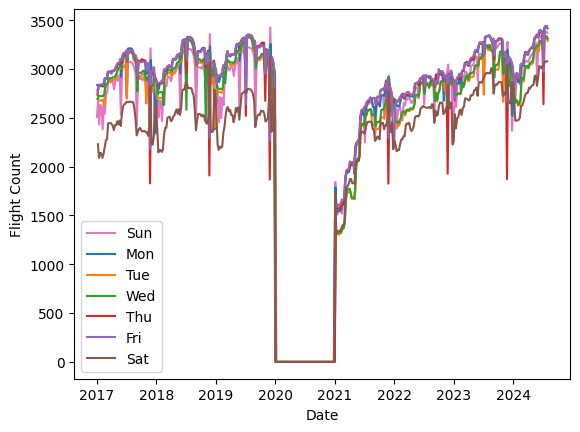

In [19]:
# plot_timeseries(df_day,hue=None)
plot_timeseries(df_day)

- Air travel trend differs for different days of the week; lowest flight count on Sat in general.
- Covid (2020) affected air travel trends significantly, 2021 most affected followed by 2022 (both were still recovery years).
- To study general air travel trend (across seasonalities), let's focus on pre-covid era: 2017 to 2019 

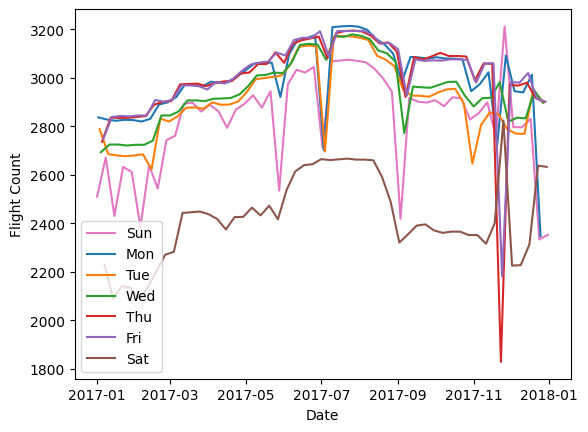

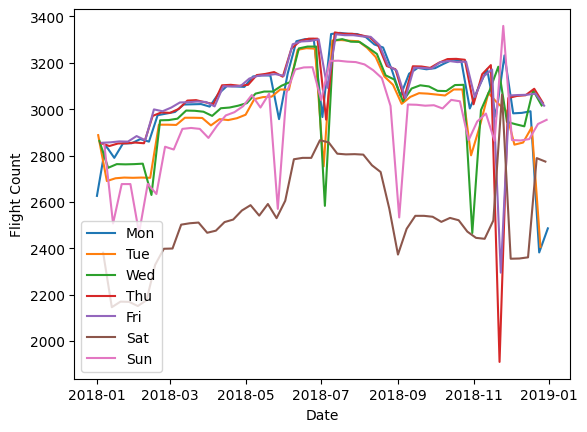

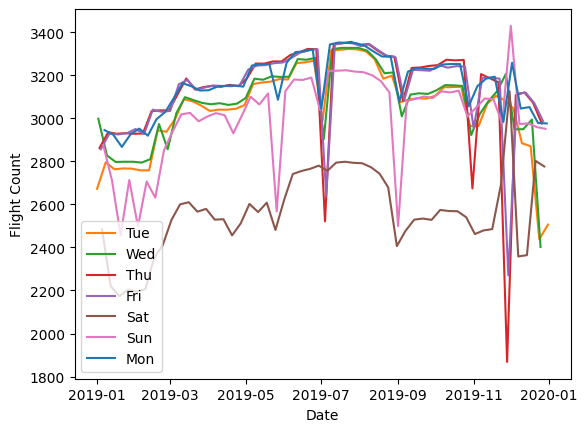

In [20]:
for year in range(2017,2020):
    plot_timeseries(df_day, year=year)

- Sharp drop in July is consistent across the three years.
- Lowest flight count on Saturday, followed by Sunday --> Price factors?

In [21]:
us_holidays = holidays.US(years=range(2017, 2024))  # holidays from 2017 to 2023

holidays_tups = []  # Holiday, Date
for date, hol in us_holidays.items():
    holidays_tups.append((hol, date))
print(holidays_tups)


[("New Year's Day", datetime.date(2017, 1, 1)), ("New Year's Day (observed)", datetime.date(2017, 1, 2)), ('Memorial Day', datetime.date(2017, 5, 29)), ('Independence Day', datetime.date(2017, 7, 4)), ('Labor Day', datetime.date(2017, 9, 4)), ('Veterans Day', datetime.date(2017, 11, 11)), ('Veterans Day (observed)', datetime.date(2017, 11, 10)), ('Thanksgiving', datetime.date(2017, 11, 23)), ('Christmas Day', datetime.date(2017, 12, 25)), ('Martin Luther King Jr. Day', datetime.date(2017, 1, 16)), ("Washington's Birthday", datetime.date(2017, 2, 20)), ('Columbus Day', datetime.date(2017, 10, 9)), ("New Year's Day", datetime.date(2018, 1, 1)), ('Memorial Day', datetime.date(2018, 5, 28)), ('Independence Day', datetime.date(2018, 7, 4)), ('Labor Day', datetime.date(2018, 9, 3)), ('Veterans Day', datetime.date(2018, 11, 11)), ('Veterans Day (observed)', datetime.date(2018, 11, 12)), ('Thanksgiving', datetime.date(2018, 11, 22)), ('Christmas Day', datetime.date(2018, 12, 25)), ('Martin Lut

In [22]:
holidays_df = pd.DataFrame(holidays_tups, columns=['Holiday', 'Date'])
holidays_df.set_index("Date", inplace=True)
holidays_df.head()

Holiday
Date                                 
2017-01-01             New Year's Day
2017-01-02  New Year's Day (observed)
2017-05-29               Memorial Day
2017-07-04           Independence Day
2017-09-04                  Labor Day

In [23]:
df_day_with_hols = pd.merge(df_day, holidays_df, left_index=True, right_index=True, how='left')
df_day_with_hols.to_csv('assets/flight2_data_byday_withhols.csv', index=False)
df_day_with_hols.head()

Flight Count  Year  Month  Week  Day Day of Week  \
Date                                                           
2017-01-01          2510  2017      1    52    1         Sun   
2017-01-02          2837  2017      1     1    2         Mon   
2017-01-03          2789  2017      1     1    3         Tue   
2017-01-04          2693  2017      1     1    4         Wed   
2017-01-05          2737  2017      1     1    5         Thu   

                              Holiday  
Date                                   
2017-01-01             New Year's Day  
2017-01-02  New Year's Day (observed)  
2017-01-03                        NaN  
2017-01-04                        NaN  
2017-01-05                        NaN

In [24]:
df_day_with_hols.loc[df_day_with_hols['Month'].isin([6,7,8]),'Holiday'] = 'School Summer Break'
df_day_with_hols['Holiday Bool'] = df_day_with_hols['Holiday'].notna().astype(int)
df_day_with_hols.head()

Flight Count  Year  Month  Week  Day Day of Week  \
Date                                                           
2017-01-01          2510  2017      1    52    1         Sun   
2017-01-02          2837  2017      1     1    2         Mon   
2017-01-03          2789  2017      1     1    3         Tue   
2017-01-04          2693  2017      1     1    4         Wed   
2017-01-05          2737  2017      1     1    5         Thu   

                              Holiday  Holiday Bool  
Date                                                 
2017-01-01             New Year's Day             1  
2017-01-02  New Year's Day (observed)             1  
2017-01-03                        NaN             0  
2017-01-04                        NaN             0  
2017-01-05                        NaN             0

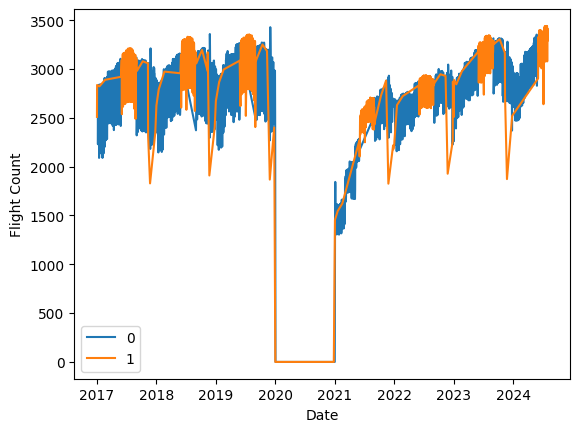

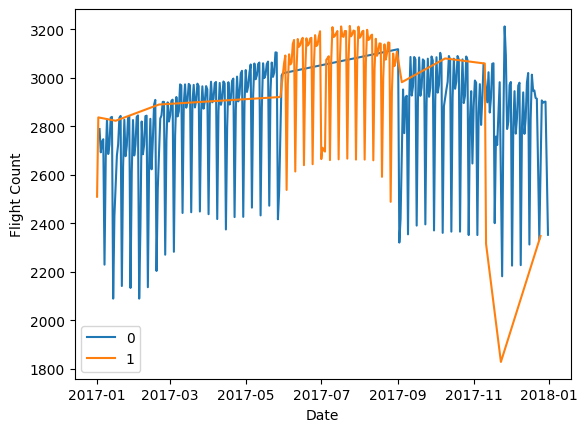

In [25]:
plot_timeseries(df_day_with_hols,y='Flight Count', year=None, hue='Holiday Bool')
plot_timeseries(df_day_with_hols,y='Flight Count', year=2017, hue='Holiday Bool')

## EDA for Trend by Air Carrier Type

In [26]:
df.head()

Airline Code Airline Airport Code  Year  Month  Day  \
Date                                                             
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   

                          Airport Name           City State Code (USPS)  \
Date                                                                      
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   

              State Name  State Code (FIPS) Carrier Type  Cluster Number  
Date                                                                      
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0

In [27]:
## To account for variation in flight volume across days of the week, take weekly average flight volume for this section of analysis
# ref_col = df.columns[0]
# S_week= df.resample(rule='W',on='Date')[ref_col].count()
# S_week.rename('Flight Count',inplace=True)
# df_week = pd.DataFrame(S_week)

# # Feature Engineering
# df_week['Year'] = df_week.index.year
# df_week['Month'] = df_week.index.month
# df_week['Week'] = df_week.index.isocalendar().week
# df_week.head()

In [28]:
# # Ensure 'Date' column is a datetime type
# df['Date'] = pd.to_datetime(df['Date'])

# # Set 'Date' as the index for resampling
# df.set_index('Date', inplace=True)

In [29]:
# Group by 'Carrier Type' and resample within each group
grouped_carrier = df.groupby('Carrier Type')
S_week_by_carrier = grouped_carrier[ref_col].apply(lambda x: x.resample('W').count())

S_week_by_carrier.rename('Flight Count', inplace=True)
df_week_by_carrier = pd.DataFrame(S_week_by_carrier.reset_index()).set_index('Date')
df_week_by_carrier['Year'] = df_week_by_carrier.index.year
df_week_by_carrier['Month'] = df_week_by_carrier.index.month
df_week_by_carrier['Week'] = df_week_by_carrier.index.isocalendar().week
df_week_by_carrier


Carrier Type  Flight Count  Year  Month  Week
Date                                                    
2017-01-01       Legacy          2051  2017      1    52
2017-01-08       Legacy         15511  2017      1     1
2017-01-15       Legacy         15247  2017      1     2
2017-01-22       Legacy         15496  2017      1     3
2017-01-29       Legacy         15475  2017      1     4
...                 ...           ...   ...    ...   ...
2024-07-07     Low-cost          3825  2024      7    27
2024-07-14     Low-cost          4047  2024      7    28
2024-07-21     Low-cost          4090  2024      7    29
2024-07-28     Low-cost          4081  2024      7    30
2024-08-04     Low-cost          1715  2024      8    31

[794 rows x 5 columns]

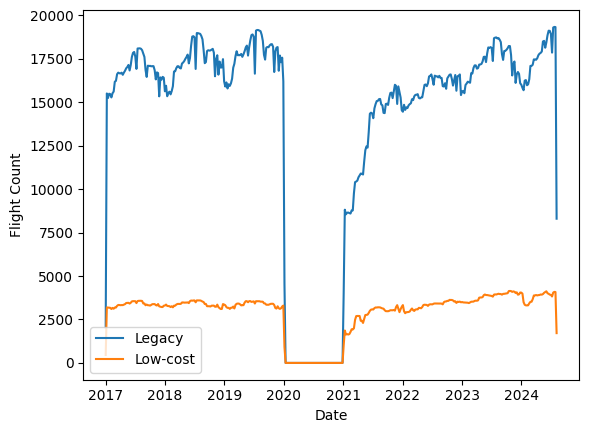

In [30]:
plot_timeseries(df_week_by_carrier,y='Flight Count', year=None, hue='Carrier Type')

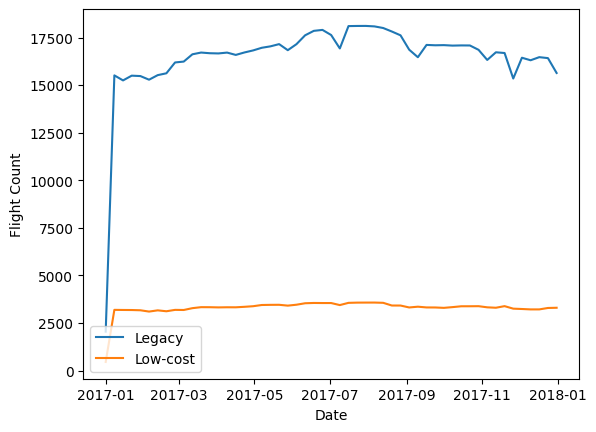

In [31]:
plot_timeseries(df_week_by_carrier,y='Flight Count', year=2017, hue='Carrier Type')

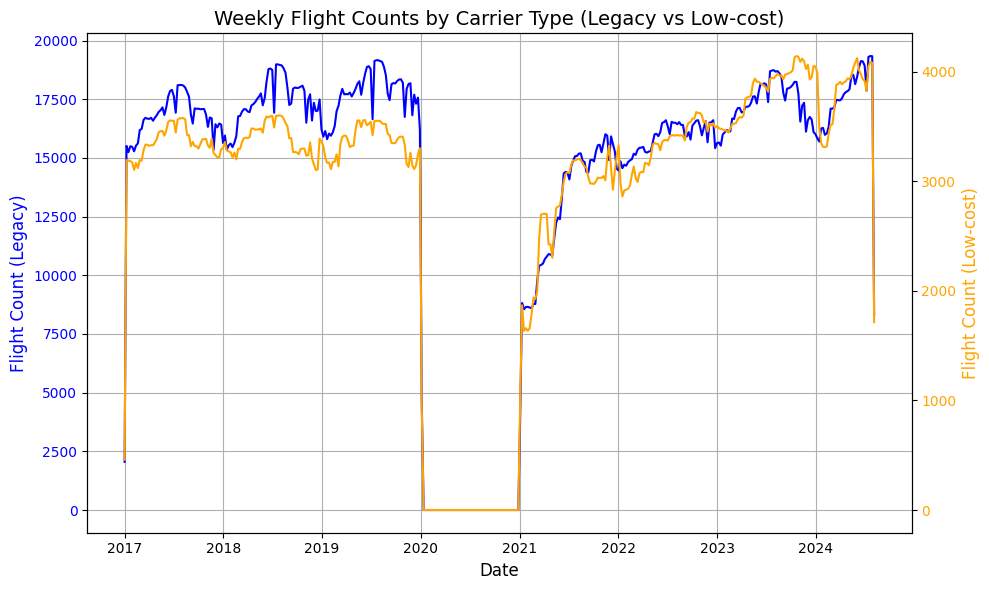

In [32]:
import matplotlib.pyplot as plt

tmp = df_week_by_carrier.copy()

# Filter the data
legacy_df = tmp[tmp['Carrier Type'] == 'Legacy']
lowcost_df = tmp[tmp['Carrier Type'] == 'Low-cost']

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Legacy on primary y-axis
ax1.plot(legacy_df.index, legacy_df['Flight Count'], label='Legacy', color='b')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Flight Count (Legacy)', fontsize=12, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create secondary y-axis for Low-cost
ax2 = ax1.twinx()
ax2.plot(lowcost_df.index, lowcost_df['Flight Count'], label='Low-cost', color='orange')
ax2.set_ylabel('Flight Count (Low-cost)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and grid
plt.title('Weekly Flight Counts by Carrier Type (Legacy vs Low-cost)', fontsize=14)
ax1.grid(True)

# Show plot
plt.tight_layout()
plt.show()


- The year-end low-cost travel trendings pre and post covid are interesting.
- Also notice how low-cost travel gain prominence post-covid.. could it be due to elevated pricing (which makes legacy carriers less affordable) 

## EDA for Trend across Clusters (via PCA-KMeans)

In [56]:
# Group by 'Cluster Number' and resample within each group
grouped_cluster = df.groupby('Cluster Number')
S_week_by_cluster = grouped_cluster[ref_col].apply(lambda x: x.resample('W').count())

S_week_by_cluster.rename('Flight Count', inplace=True)
df_week_by_cluster = pd.DataFrame(S_week_by_cluster.reset_index()).set_index('Date')
df_week_by_cluster['Year'] = df_week_by_cluster.index.year
df_week_by_cluster['Month'] = df_week_by_cluster.index.month
df_week_by_cluster['Week'] = df_week_by_cluster.index.isocalendar().week
df_week_by_cluster.head()

Cluster Number  Flight Count  Year  Month  Week
Date                                                       
2017-01-01               0           884  2017      1    52
2017-01-08               0          7086  2017      1     1
2017-01-15               0          7274  2017      1     2
2017-01-22               0          7406  2017      1     3
2017-01-29               0          7382  2017      1     4

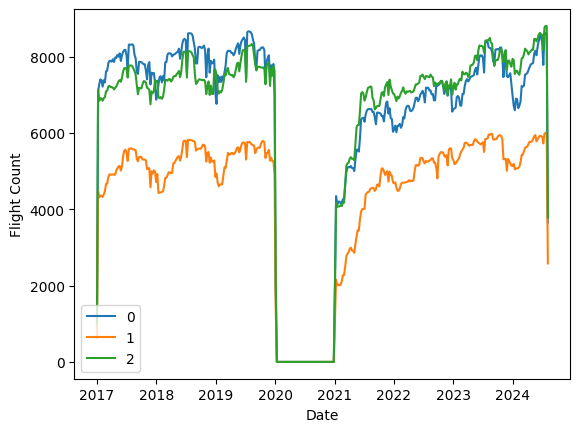

In [59]:
plot_timeseries(df_week_by_cluster,y='Flight Count', year=None, hue='Cluster Number')

- note the reversal in net air travel volume between cluster 0 and 2 post-covid

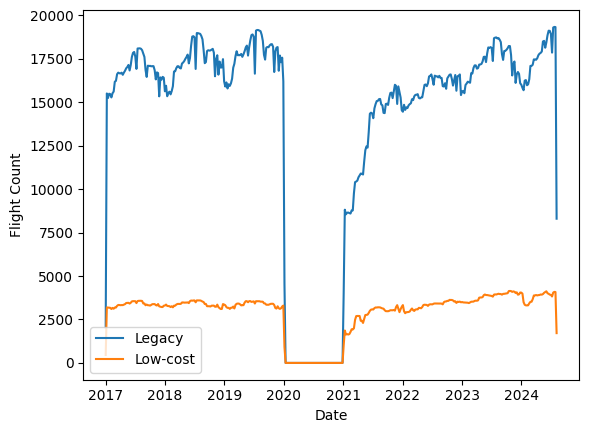

In [60]:
#compare to by carrier type
plot_timeseries(df_week_by_carrier,y='Flight Count', year=None, hue='Carrier Type')

- Don't match exactly. Carrier type and Cluster number could be two intrinsic features that both influence air travel demand

## EDA for Trend across Cluster Number + Carrier Type

In [70]:
# Group by 'Cluster Number' & Carrier Type (cc) and resample within each group
grouped_cc = df.groupby(['Cluster Number','Carrier Type'])
S_week_by_cc = grouped_cc[ref_col].apply(lambda x: x.resample('W').count())

S_week_by_cc.rename('Flight Count', inplace=True)
df_week_by_cc = pd.DataFrame(S_week_by_cc.reset_index()).set_index('Date')
df_week_by_cc['Year'] = df_week_by_cc.index.year
df_week_by_cc['Month'] = df_week_by_cc.index.month
df_week_by_cc['Week'] = df_week_by_cc.index.isocalendar().week
df_week_by_cc['Cluster_Carrier'] = df_week_by_cc.apply(lambda row: f"Cluster{row['Cluster Number']}_{row['Carrier Type']}", axis=1)

df_week_by_cc.head()

Cluster Number Carrier Type  Flight Count  Year  Month  Week  \
Date                                                                       
2017-01-01               0       Legacy           669  2017      1    52   
2017-01-08               0       Legacy          5607  2017      1     1   
2017-01-15               0       Legacy          5794  2017      1     2   
2017-01-22               0       Legacy          5930  2017      1     3   
2017-01-29               0       Legacy          5907  2017      1     4   

            Cluster_Carrier  
Date                         
2017-01-01  Cluster0_Legacy  
2017-01-08  Cluster0_Legacy  
2017-01-15  Cluster0_Legacy  
2017-01-22  Cluster0_Legacy  
2017-01-29  Cluster0_Legacy

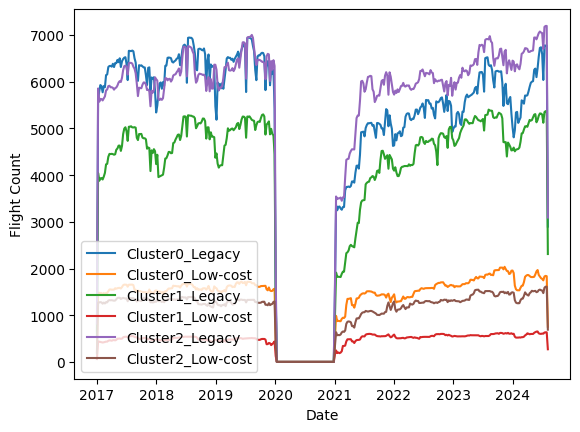

In [71]:
plot_timeseries(df_week_by_cc,y='Flight Count', year=None, hue='Cluster_Carrier')

- Indeed both independently affect air travel trend
- Relative trending for each combination is rather clear and consistent.
- Interestingly, travel trend across clusters differ for each carrier type, additionally pre- and post- covid trends differ for air travel with legacy carriers:
**Key Observations**:
- i. Legacy (pre-covid): 0 > 2 > 1 
- ii.  Legacy (post-covid): 2 > 0 > 1 
- iii. Low-cost (pre and post covid): 0 > 2 > 1
- Cluster 1: least air travel regardless of carrier types or timeframe (pre/post covid)


Given these observations, the strategy for ARIMA modelling (weekly trending) will be:
1. Two individual models pre- and post- covid period (varying dominance of seasonality and differencing)
2. Consider both carrier type and cluster number. -- evaluate improvement in model performance in accounting for each of the factors.

In [73]:
# Group by 'Cluster Number' & Airline (ca) and resaple within each group
grouped_ca = df.groupby(['Cluster Number','Airline'])
S_week_by_ca = grouped_ca[ref_col].apply(lambda x: x.resample('W').count())

S_week_by_ca.rename('Flight Count', inplace=True)
df_week_by_ca = pd.DataFrame(S_week_by_ca.reset_index()).set_index('Date')
df_week_by_ca['Year'] = df_week_by_ca.index.year
df_week_by_ca['Month'] = df_week_by_ca.index.month
df_week_by_ca['Week'] = df_week_by_ca.index.isocalendar().week
df_week_by_ca['Cluster_Airline'] = df_week_by_ca.apply(lambda row: f"Cluster{row['Cluster Number']}_{row['Airline']}", axis=1)

df_week_by_ca.head()

Cluster Number   Airline  Flight Count  Year  Month  Week  \
Date                                                                    
2017-01-01               0  American           149  2017      1    52   
2017-01-08               0  American          1133  2017      1     1   
2017-01-15               0  American          1062  2017      1     2   
2017-01-22               0  American          1066  2017      1     3   
2017-01-29               0  American          1066  2017      1     4   

              Cluster_Airline  
Date                           
2017-01-01  Cluster0_American  
2017-01-08  Cluster0_American  
2017-01-15  Cluster0_American  
2017-01-22  Cluster0_American  
2017-01-29  Cluster0_American

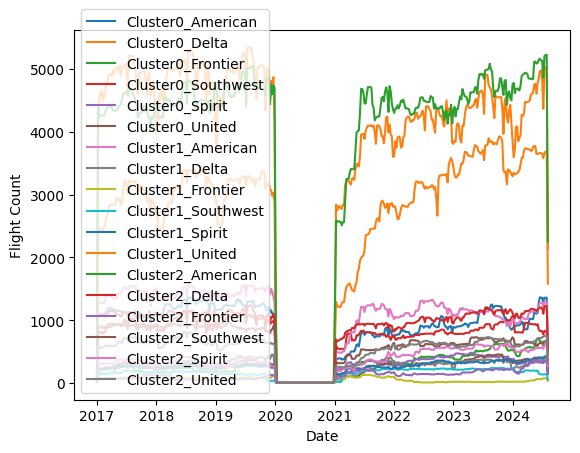

In [74]:
plot_timeseries(df_week_by_ca,y='Flight Count', year=None, hue='Cluster_Airline')

- Seems like there could be a dominant airline for each of the clusters. Let's explore this trend cluster by cluster.

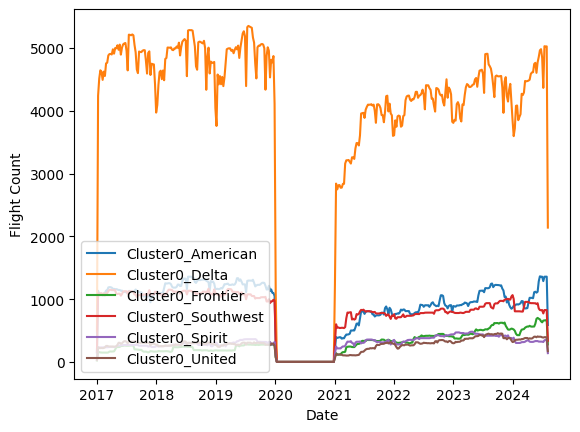

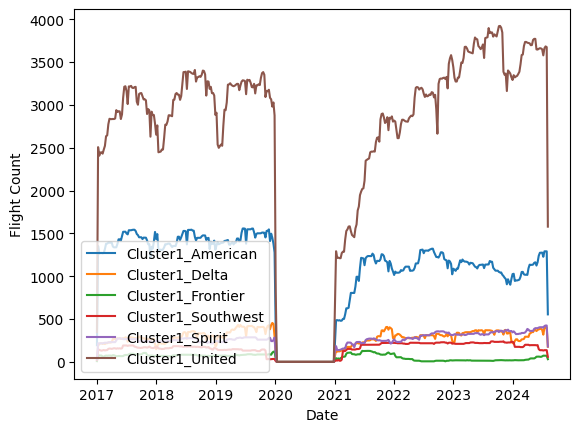

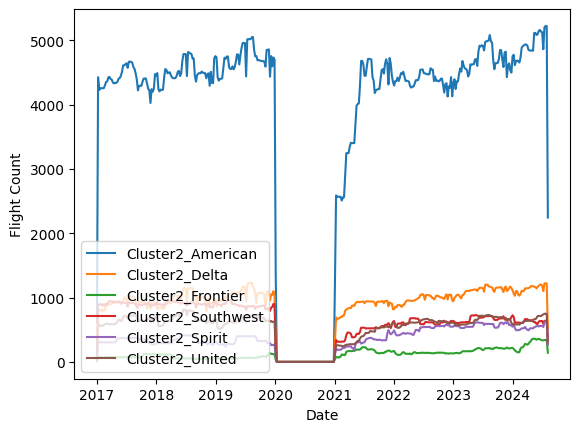

In [75]:
for cluster in df_week_by_ca['Cluster Number'].unique():
    tmp = df_week_by_ca[df_week_by_ca['Cluster Number'] ==cluster]
    plot_timeseries(tmp,y='Flight Count', year=None, hue='Cluster_Airline')

- Indeed each cluster does have their own dominant airline(s) but limited to the legacy carriers (due to the sheer volume of operation). 
- But we also want to include the low-cost airlines. On another persepective, to include both types of air carriers, let's look into cluster dominance in each carrier type/ airline.

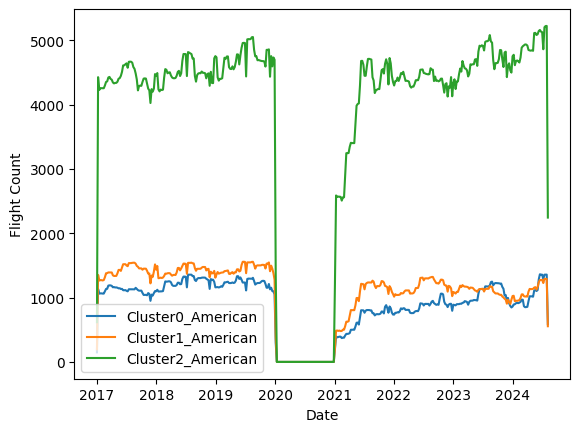

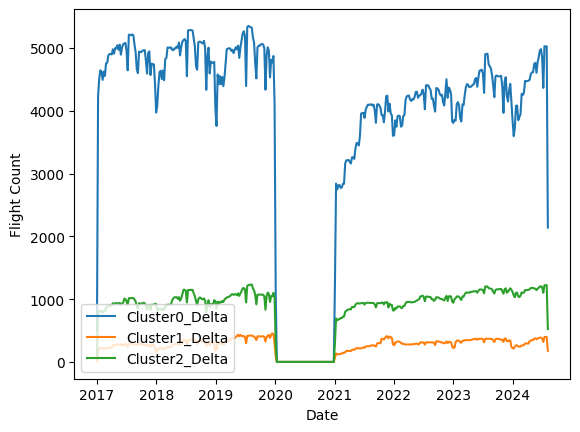

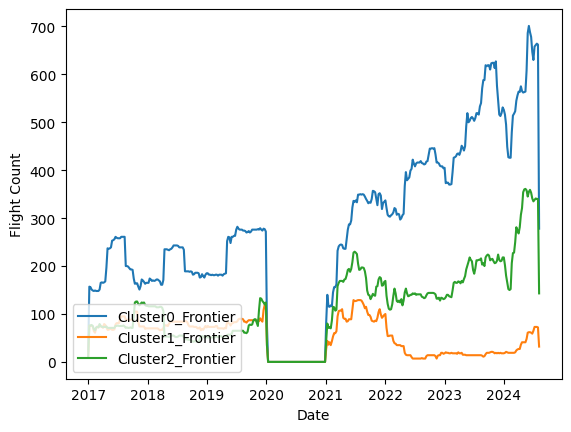

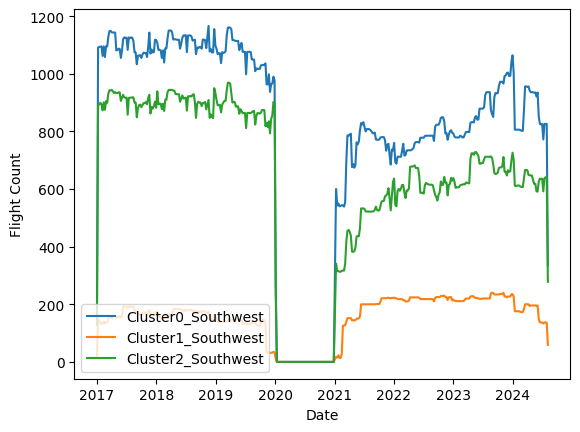

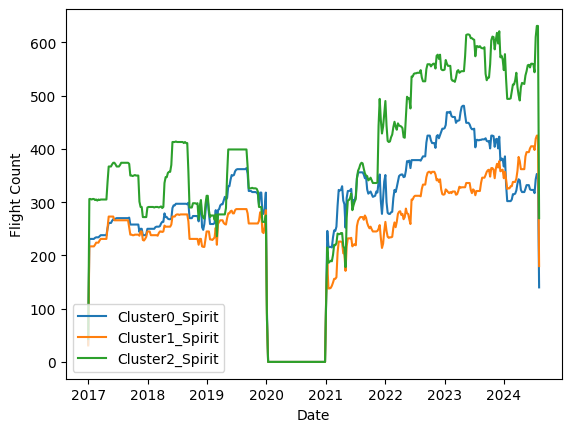

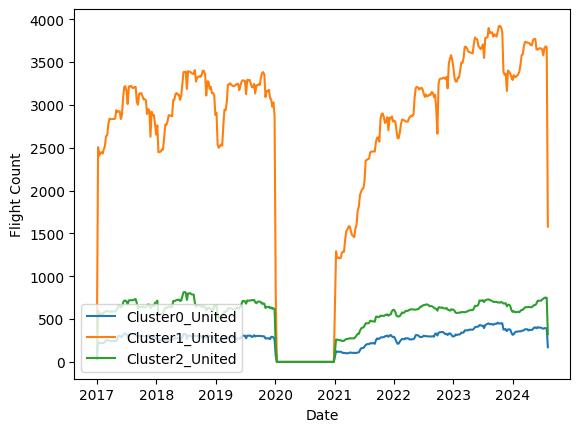

In [77]:
for airline in df_week_by_ca['Airline'].unique():
    tmp = df_week_by_ca[df_week_by_ca['Airline'] == airline]
    plot_timeseries(tmp,y='Flight Count', year=None, hue='Cluster_Airline')

**Main Clusters for each Airline**
- American: #2
- Delta: #0
- Frontier: #0 (+2,1 post-covid)
- Southwest: #0,1
- Spirit: #2, (0,1)
- United: #1 

.. Looks like a decent selection of airlines/airports.

## EDA for Trend across Days of a week by Carrier Type

In [33]:
df.head()

Airline Code Airline Airport Code  Year  Month  Day  \
Date                                                             
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   

                          Airport Name           City State Code (USPS)  \
Date                                                                      
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   

              State Name  State Code (FIPS) Carrier Type  Cluster Number  
Date                                                                      
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0

In [34]:
legacy_df = df[df['Carrier Type'] == 'Legacy']
lowcost_df = df[df['Carrier Type'] == 'Low-cost']

In [35]:
ref_col = df.columns[0]

S_day_legacy = legacy_df.resample(rule='D')[ref_col].count()
S_day_legacy.rename('Flight Count',inplace=True)
df_day_legacy = pd.DataFrame(S_day_legacy)
df_day_legacy.loc[:,'Carrier Type'] = 'Legacy'
df_day_legacy['Year'] = df_day.index.year
df_day_legacy['Month'] = df_day.index.month
df_day_legacy['Week'] = df_day.index.isocalendar().week
df_day_legacy['Day'] = df_day.index.day
df_day_legacy['Day of Week'] = df_day_legacy.index.dayofweek # 0 = Monday, 6 = Sunday
# dayofweek_mapper = dict(zip(np.arange(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']))
df_day_legacy['Day of Week'] = df_day_legacy['Day of Week'].map(dayofweek_mapper)
df_day_legacy.to_csv('assets/flight2_data_byday_legacy.csv')
df_day_legacy.head()

Flight Count Carrier Type  Year  Month  Week  Day Day of Week
Date                                                                     
2017-01-01          2051       Legacy  2017      1    52    1         Sun
2017-01-02          2359       Legacy  2017      1     1    2         Mon
2017-01-03          2304       Legacy  2017      1     1    3         Tue
2017-01-04          2235       Legacy  2017      1     1    4         Wed
2017-01-05          2267       Legacy  2017      1     1    5         Thu

In [36]:
S_day_lowcost = lowcost_df.resample(rule='D')[ref_col].count()
S_day_lowcost.rename('Flight Count',inplace=True)
df_day_lowcost = pd.DataFrame(S_day_lowcost)
df_day_lowcost.loc[:,'Carrier Type'] = 'Low-cost'
df_day_lowcost['Year'] = df_day.index.year
df_day_lowcost['Month'] = df_day.index.month
df_day_lowcost['Week'] = df_day.index.isocalendar().week
df_day_lowcost['Day'] = df_day.index.day
df_day_lowcost['Day of Week'] = df_day_lowcost.index.dayofweek # 0 = Monday, 6 = Sunday
# dayofweek_mapper = dict(zip(np.arange(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']))
df_day_lowcost['Day of Week'] = df_day_lowcost['Day of Week'].map(dayofweek_mapper)
df_day_lowcost.to_csv('assets/flight2_data_byday_lowcost.csv')
df_day_lowcost.head()

Flight Count Carrier Type  Year  Month  Week  Day Day of Week
Date                                                                     
2017-01-01           459     Low-cost  2017      1    52    1         Sun
2017-01-02           478     Low-cost  2017      1     1    2         Mon
2017-01-03           485     Low-cost  2017      1     1    3         Tue
2017-01-04           458     Low-cost  2017      1     1    4         Wed
2017-01-05           470     Low-cost  2017      1     1    5         Thu

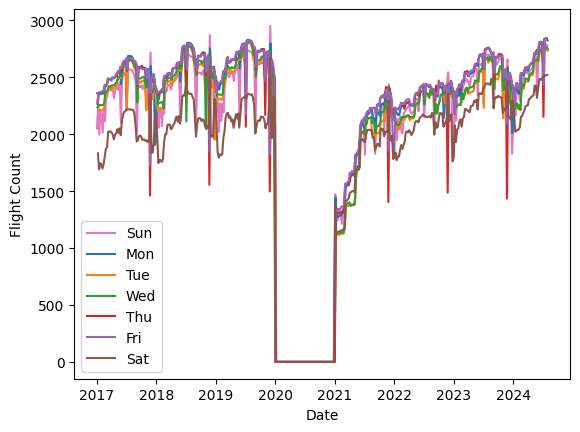

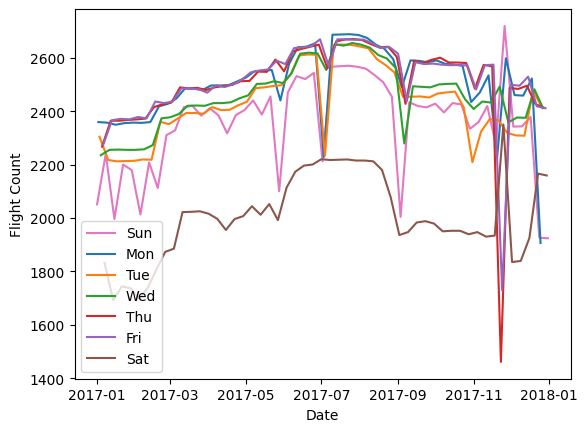

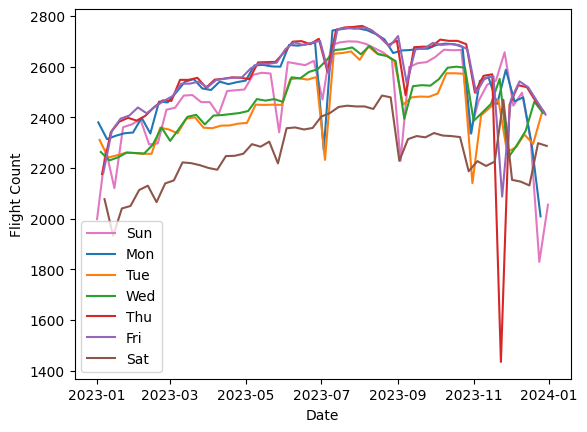

In [37]:
tmp=df_day_legacy
plot_timeseries(tmp,y='Flight Count', year=None, hue='Day of Week')
plot_timeseries(tmp,y='Flight Count', year=2017, hue='Day of Week')
plot_timeseries(tmp,y='Flight Count', year=2023, hue='Day of Week')

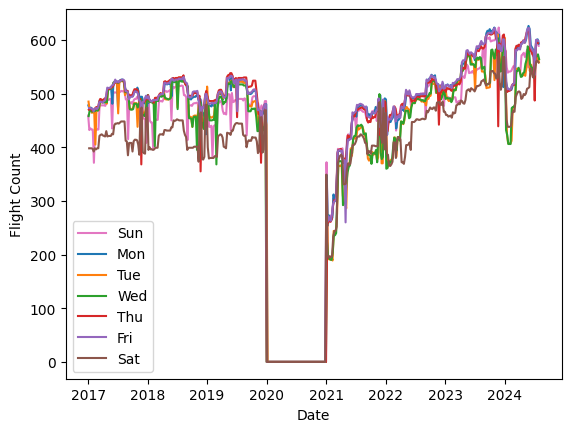

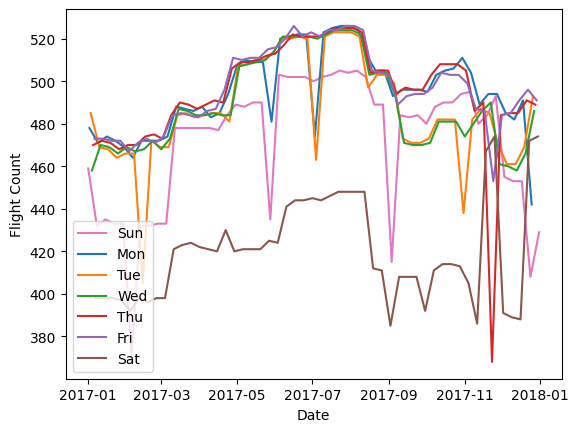

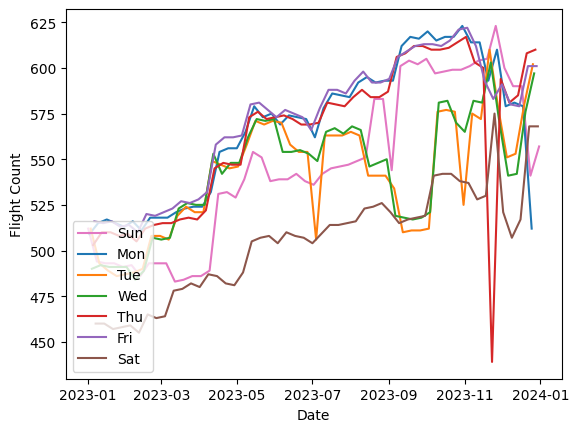

In [38]:
tmp=df_day_lowcost
plot_timeseries(tmp,y='Flight Count', year=None, hue='Day of Week')
plot_timeseries(tmp,y='Flight Count', year=2017, hue='Day of Week')
plot_timeseries(tmp,y='Flight Count', year=2023, hue='Day of Week')

## EDA for Trend by Airline

In [39]:
df.head()

Airline Code Airline Airport Code  Year  Month  Day  \
Date                                                             
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   
2017-01-01           DL   Delta          PHL  2017      1    1   

                          Airport Name           City State Code (USPS)  \
Date                                                                      
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   
2017-01-01  Philadelphia International   Philadelphia                PA   

              State Name  State Code (FIPS) Carrier Type  Cluster Number  
Date                                                                      
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0  
2017-01-01  Pennsylvania               42.0       Legacy               0

In [40]:
df_day_by_airline = df.groupby('Airline').resample(rule='D')[df.columns[0]].count()
df_day_by_airline = df_day_by_airline.rename("Flight Count")
df_day_by_airline = df_day_by_airline.reset_index()  
df_day_by_airline.set_index('Date',inplace=True)
df_day_by_airline['Year'] = df_day_by_airline.index.year
df_day_by_airline.to_csv('assets/flight_data2_byday_byairline.csv')
df_day_by_airline.head()

Airline  Flight Count  Year
Date                                    
2017-01-01  American           962  2017
2017-01-02  American          1030  2017
2017-01-03  American          1002  2017
2017-01-04  American           994  2017
2017-01-05  American           996  2017

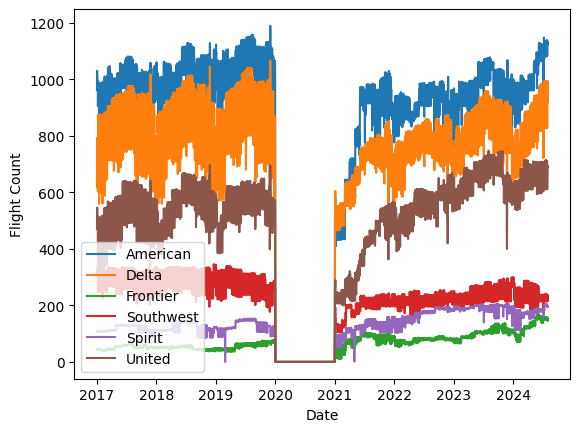

In [41]:
tmp=df_day_by_airline
plot_timeseries(tmp,y='Flight Count',year=None,hue='Airline')

In [42]:
airlines

['Delta', 'American', 'United', 'Southwest', 'Spirit', 'Frontier']

In [43]:
airlines_lowcost = airlines[3:]
airlines_legacy = airlines[:3]

In [44]:
airlines_lowcost

['Southwest', 'Spirit', 'Frontier']

In [45]:
df_day_by_airline_legacy = df_day_by_airline[df_day_by_airline['Airline'].isin(airlines_legacy)]
df_day_by_airline_lowcost = df_day_by_airline[df_day_by_airline['Airline'].isin(airlines_lowcost)]

In [46]:
df_day_by_airline_lowcost 

Airline  Flight Count  Year
Date                                    
2017-01-01  Frontier            43  2017
2017-01-02  Frontier            43  2017
2017-01-03  Frontier            46  2017
2017-01-04  Frontier            44  2017
2017-01-05  Frontier            45  2017
...              ...           ...   ...
2024-07-27    Spirit           195  2024
2024-07-28    Spirit           199  2024
2024-07-29    Spirit           200  2024
2024-07-30    Spirit           195  2024
2024-07-31    Spirit           195  2024

[8307 rows x 3 columns]

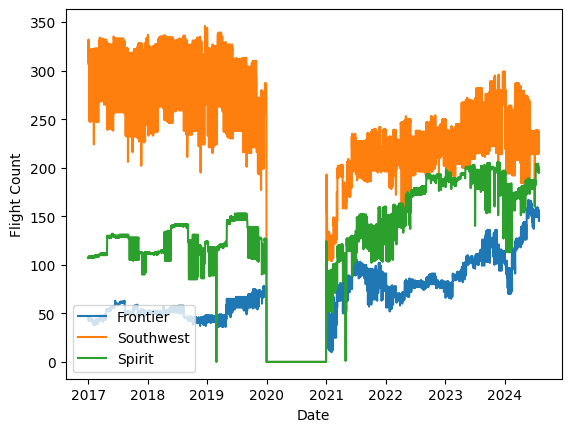

In [47]:
tmp=df_day_by_airline_lowcost
plot_timeseries(tmp,y='Flight Count',year=None,hue='Airline')

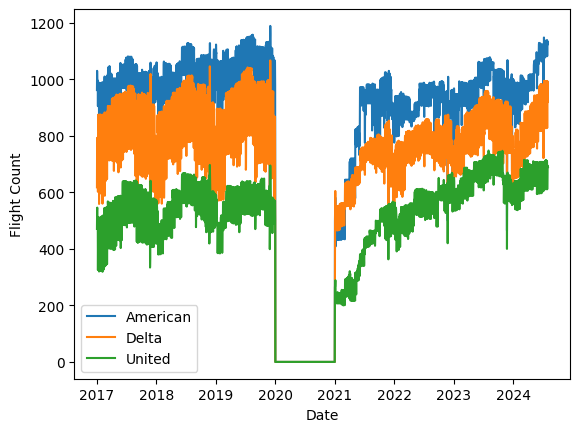

In [48]:
tmp=df_day_by_airline_legacy
plot_timeseries(tmp,y='Flight Count',year=None,hue='Airline')

In [49]:
df_week_by_airline = df.groupby('Airline').resample('W')[df.columns[0]].count()
df_week_by_airline.rename('Flight Count', inplace=True)
df_week_by_airline = df_week_by_airline.reset_index().set_index('Date')
df_week_by_airline['Year']= df_week_by_airline.index.year
df_week_by_airline.to_csv('assets/flight_data2_byweek_byairline.csv')
df_week_by_airline.head()

Airline  Flight Count  Year
Date                                    
2017-01-01  American           962  2017
2017-01-08  American          6915  2017
2017-01-15  American          6557  2017
2017-01-22  American          6596  2017
2017-01-29  American          6595  2017

In [50]:
df_week_by_airline_legacy = df_week_by_airline[df_week_by_airline['Airline'].isin(airlines_legacy)]
df_week_by_airline_lowcost = df_week_by_airline[df_week_by_airline['Airline'].isin(airlines_lowcost)]

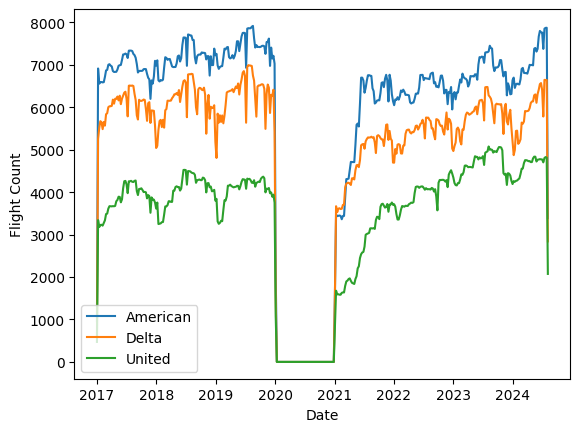

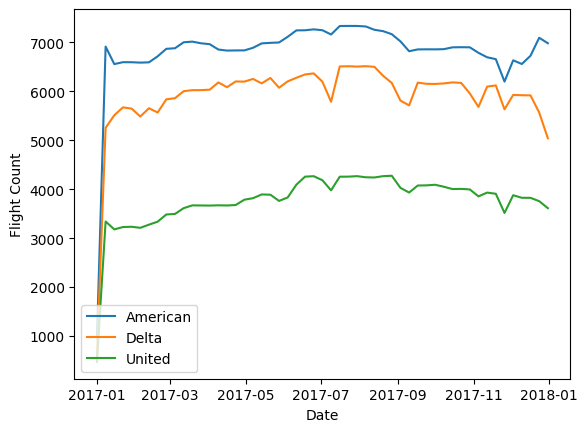

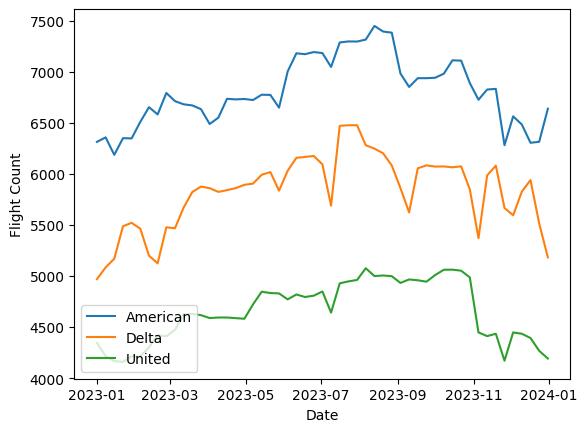

In [51]:
tmp=df_week_by_airline_legacy
plot_timeseries(tmp,y='Flight Count',year=None,hue='Airline')
plot_timeseries(tmp,y='Flight Count',year=2017,hue='Airline')
plot_timeseries(tmp,y='Flight Count',year=2023,hue='Airline')

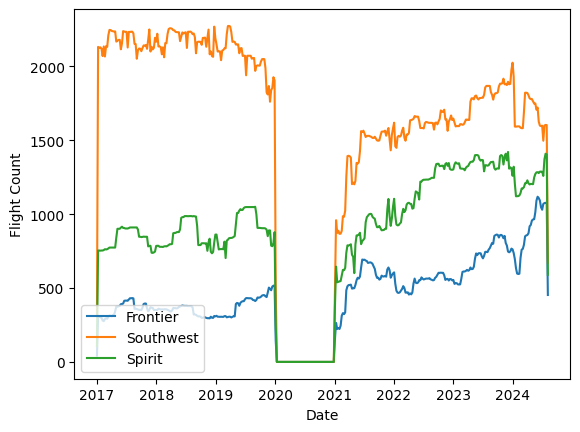

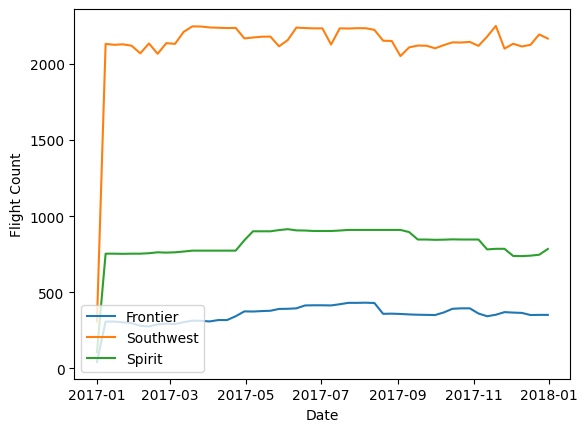

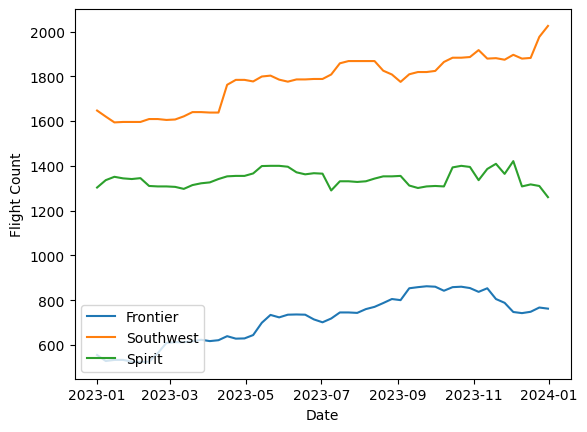

In [52]:
tmp=df_week_by_airline_lowcost
plot_timeseries(tmp,y='Flight Count',year=None,hue='Airline')
plot_timeseries(tmp,y='Flight Count',year=2017,hue='Airline')
plot_timeseries(tmp,y='Flight Count',year=2023,hue='Airline')

- Overall, travel trend with legacy carriers is more consistently sensitive to seasonality.
- Low-cost carriers show varying trends, but generally weaker sensitivity to seasonality.

# Supervised Learning

In [78]:
# 1. To remove fluctuations in travel demand across days of the week, let's first build a model for weekly average air travel
# 2. Divide the modelling into two parts: post-covid and pre-covid given the variations in trending and potentially order of differencing.
# 3. For the first sets of model, let's not include any external factors for partitioning yet and evaluate how SARIMA performs.





In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

# Example usage
adf_test(your_time_series)
